In [ ]:
import SplineLinearLayer
import KAN

In [10]:
class KANTimeSeries(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_knots=5, spline_order=3,
                 noise_scale=0.1, base_scale=1.0, spline_scale=1.0,
                 activation=nn.SiLU, grid_epsilon=0.02, grid_range=[-1, 1]):
        super(KANTimeSeries, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        self.layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(SplineLinearLayer(prev_size, hidden_size, num_knots, spline_order,
                                                 noise_scale, base_scale, spline_scale,
                                                 activation, grid_epsilon, grid_range))
            prev_size = hidden_size

        self.output_layer = SplineLinearLayer(prev_size, output_size, num_knots, spline_order,
                                              noise_scale, base_scale, spline_scale,
                                              activation, grid_epsilon, grid_range)

    def forward(self, x, update_knots=False):
        for layer in self.layers:
            if update_knots:
                layer._update_knots(x)
            x = layer(x)

        if update_knots:
            self.output_layer._update_knots(x)
        x = self.output_layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        loss = 0
        for layer in self.layers:
            loss += layer._regularization_loss(regularize_activation, regularize_entropy)
        loss += self.output_layer._regularization_loss(regularize_activation, regularize_entropy)
        return loss

# Using mlp


In [28]:
import torch
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# KAN Implementation

# Load the Air Passengers dataset
data_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(data_url)
passengers_data = df["Passengers"].values.astype(np.float32)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
passengers_data_normalized = scaler.fit_transform(passengers_data.reshape(-1, 1)).flatten()

# Create input-output sequences for the time series data
def create_sequences(series, window_size):
    sequences = []
    for i in range(len(series) - window_size):
        sequences.append((series[i:i+window_size], series[i+window_size]))
    return sequences

window_size = 1  # Define the window size for input sequences
sequences = create_sequences(passengers_data_normalized, window_size)

# Convert data to PyTorch tensors
inputs_torch = torch.tensor([seq[0] for seq in sequences], dtype=torch.float32)
targets_torch = torch.tensor([seq[1] for seq in sequences], dtype=torch.float32)

# Initialize the KANTimeSeries model
input_size = window_size
hidden_sizes = [32]  
num_knots = 5  
spline_order = 3  
model_torch = KANTimeSeries(input_size, hidden_sizes, 1, num_knots, spline_order)  # 1 for output_size

# Define the optimizer and loss function for KAN
optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=0.01)
criterion_torch = torch.nn.MSELoss()

# Training loop for KAN
epochs = 20
losses_torch = []  # To store the losses during training
for epoch in range(epochs):
    epoch_loss = 0.0
    model_torch.train()
    for i in range(len(inputs_torch)):
        optimizer_torch.zero_grad()
        output = model_torch(inputs_torch[i:i+1])  # Take one sequence at a time
        loss = criterion_torch(output, targets_torch[i:i+1])
        loss.backward()
        optimizer_torch.step()
        epoch_loss += loss.item()

    # Print the epoch loss
    epoch_loss /= len(inputs_torch)
    print(f'KAN: Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}')
    losses_torch.append(epoch_loss)

    # Calculate predictions after each epoch for KAN
    with torch.no_grad():
        all_outputs_torch = model_torch(inputs_torch).squeeze().numpy()


# MLP Implementation
# Define the MLP model using Keras
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(window_size,)),
    tf.keras.layers.Dense(1)
])

# Compile the model
model_tf.compile(optimizer='adam', loss='mean_squared_error')

# Training loop with storing loss values for MLP
losses_tf = []  
for epoch in range(epochs):
    history = model_tf.fit(inputs_torch.numpy(), targets_torch.numpy(), epochs=1, verbose=0)
    loss = history.history['loss'][0]
    losses_tf.append(loss)
    print(f"TensorFlow/Keras: Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")

# Making predictions for MLP
predicted_data_normalized_tf = model_tf.predict(inputs).flatten()

# Inverse transform the normalized data for KAN
passengers_data_denormalized_torch = scaler.inverse_transform(passengers_data_normalized.reshape(-1, 1)).flatten()
predicted_data_denormalized_torch = scaler.inverse_transform(all_outputs_torch.reshape(-1, 1)).flatten()

# Inverse transform the normalized data for MLP
passengers_data_denormalized_tf = scaler.inverse_transform(passengers_data_normalized.reshape(-1, 1)).flatten()
predicted_data_denormalized_tf = scaler.inverse_transform(predicted_data_normalized_tf.reshape(-1, 1)).flatten()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KAN: Epoch [1/20], Loss: 0.029777
KAN: Epoch [2/20], Loss: 0.011976
KAN: Epoch [3/20], Loss: 0.011085
KAN: Epoch [4/20], Loss: 0.008424
KAN: Epoch [5/20], Loss: 0.008708
KAN: Epoch [6/20], Loss: 0.008413
KAN: Epoch [7/20], Loss: 0.008137
KAN: Epoch [8/20], Loss: 0.007856
KAN: Epoch [9/20], Loss: 0.007590
KAN: Epoch [10/20], Loss: 0.007347
KAN: Epoch [11/20], Loss: 0.007134
KAN: Epoch [12/20], Loss: 0.006941
KAN: Epoch [13/20], Loss: 0.006738
KAN: Epoch [14/20], Loss: 0.006520
KAN: Epoch [15/20], Loss: 0.006273
KAN: Epoch [16/20], Loss: 0.006109
KAN: Epoch [17/20], Loss: 0.005707
KAN: Epoch [18/20], Loss: 0.005737
KAN: Epoch [19/20], Loss: 0.005492
KAN: Epoch [20/20], Loss: 0.005502


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow/Keras: Epoch 1/20, Loss: 0.145956
TensorFlow/Keras: Epoch 2/20, Loss: 0.124264
TensorFlow/Keras: Epoch 3/20, Loss: 0.105369
TensorFlow/Keras: Epoch 4/20, Loss: 0.088587
TensorFlow/Keras: Epoch 5/20, Loss: 0.074478
TensorFlow/Keras: Epoch 6/20, Loss: 0.062135
TensorFlow/Keras: Epoch 7/20, Loss: 0.051439
TensorFlow/Keras: Epoch 8/20, Loss: 0.042516
TensorFlow/Keras: Epoch 9/20, Loss: 0.035416
TensorFlow/Keras: Epoch 10/20, Loss: 0.029996
TensorFlow/Keras: Epoch 11/20, Loss: 0.025145
TensorFlow/Keras: Epoch 12/20, Loss: 0.022171
TensorFlow/Keras: Epoch 13/20, Loss: 0.019797
TensorFlow/Keras: Epoch 14/20, Loss: 0.018162
TensorFlow/Keras: Epoch 15/20, Loss: 0.017070
TensorFlow/Keras: Epoch 16/20, Loss: 0.016365
TensorFlow/Keras: Epoch 17/20, Loss: 0.015693
TensorFlow/Keras: Epoch 18/20, Loss: 0.015170
TensorFlow/Keras: Epoch 19/20, Loss: 0.014739
TensorFlow/Keras: Epoch 20/20, Loss: 0.014382
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


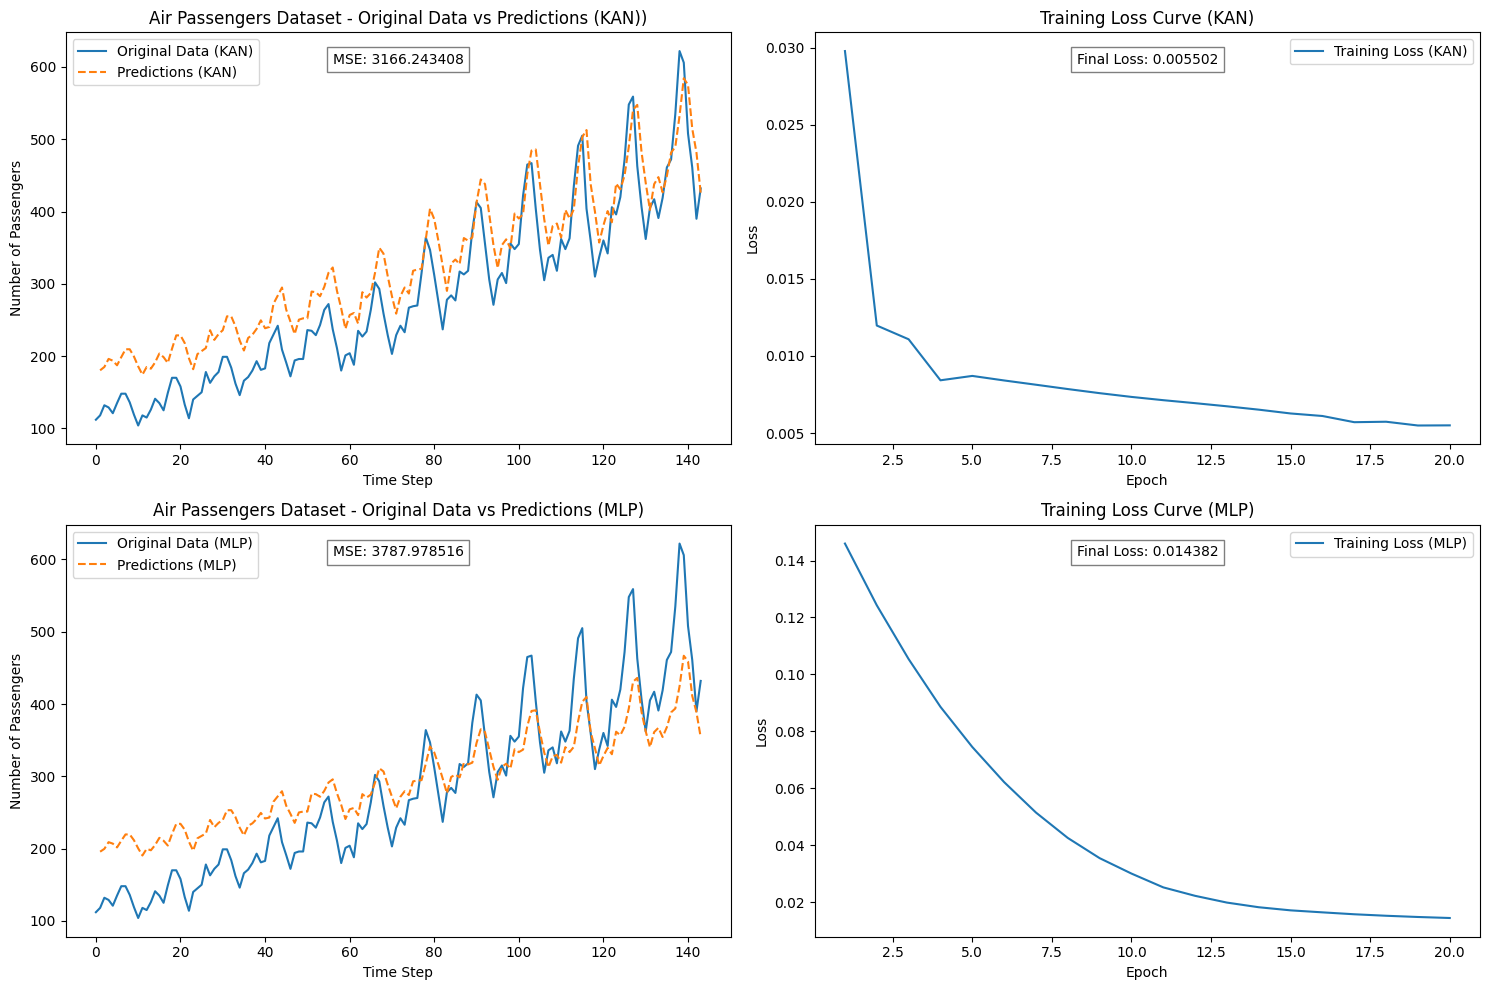

In [30]:
# Calculate MSE for PyTorch
mse_torch = np.mean((passengers_data_denormalized_torch[window_size:] - predicted_data_denormalized_torch) ** 2)

# Calculate MSE for TensorFlow/Keras
mse_tf = np.mean((passengers_data_denormalized_tf[window_size:] - predicted_data_denormalized_tf) ** 2)

# Plotting side by side with loss curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot original data and predictions for PyTorch
axes[0, 0].plot(passengers_data_denormalized_torch, label='Original Data (KAN)')
axes[0, 0].plot(np.arange(window_size, len(passengers_data_denormalized_torch)), predicted_data_denormalized_torch, label='Predictions (KAN)', linestyle='--')
axes[0, 0].set_title('Air Passengers Dataset - Original Data vs Predictions (KAN))')
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('Number of Passengers')
axes[0, 0].legend()
axes[0, 0].text(0.5, 0.95, f'MSE: {mse_torch:.6f}', transform=axes[0, 0].transAxes, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Plot loss curve for KAN
axes[0, 1].plot(range(1, epochs+1), losses_torch, label='Training Loss (KAN)')
axes[0, 1].set_title('Training Loss Curve (KAN)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].text(0.5, 0.95, f'Final Loss: {losses_torch[-1]:.6f}', transform=axes[0, 1].transAxes, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Plot original data and predictions for MLP
axes[1, 0].plot(passengers_data_denormalized_tf, label='Original Data (MLP)')
axes[1, 0].plot(np.arange(window_size, len(passengers_data_denormalized_tf)), predicted_data_denormalized_tf, label='Predictions (MLP)', linestyle='--')
axes[1, 0].set_title('Air Passengers Dataset - Original Data vs Predictions (MLP)')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Number of Passengers')
axes[1, 0].legend()
axes[1, 0].text(0.5, 0.95, f'MSE: {mse_tf:.6f}', transform=axes[1, 0].transAxes, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Plot loss curve for MLP
axes[1, 1].plot(range(1, epochs+1), losses_tf, label='Training Loss (MLP)')
axes[1, 1].set_title('Training Loss Curve (MLP)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].text(0.5, 0.95, f'Final Loss: {losses_tf[-1]:.6f}', transform=axes[1, 1].transAxes, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

#### I haven't optimized the KAN model; we can perform hyperparameter tuning to potentially achieve better results